# referred to https://github.com/yoheikikuta/bert-japanese/blob/master/notebook/finetune-to-livedoor-corpus.ipynb by "yoheikikuta"

In [39]:
import sys
import tensorflow as tf
import configparser
import json
import glob
import os
import pandas as pd
import tempfile
from sklearn.metrics import classification_report, confusion_matrix

sys.path.append("bert-japanese/src/")
import tokenization_sentencepiece as tokenization
from run_classifier import LivedoorProcessor
from run_classifier import model_fn_builder
from run_classifier import file_based_input_fn_builder
from run_classifier import file_based_convert_examples_to_features
from utils import str_to_value
import modeling
import optimization

In [52]:
CONFIGPATH = os.path.join(os.getcwd(), "bert-japanese/", 'config.ini')
config = configparser.ConfigParser()
config.read(CONFIGPATH)
print("config data is read")

config data is read


In [19]:
PRETRAINED_MODEL_PATH = "bert-japanese/model/pretrain/model.ckpt-1300000"
FINETUNE_OUTPUT_DIR = "bert-japanese/model/livedoor_output"

In [20]:
bert_config_file = tempfile.NamedTemporaryFile(mode="w+t", encoding="utf-8", suffix=".json")
bert_config_file.write(json.dumps({k:str_to_value(v) for k, v in config["BERT-CONFIG"].items()}))
bert_config_file.seek(0)
bert_config = modeling.BertConfig.from_json_file(bert_config_file.name)

In [23]:
output_ckpts = glob.glob("{}/model.ckpt*data*".format(FINETUNE_OUTPUT_DIR))
latest_ckpt = sorted(output_ckpts)[-1]
FINETUNE_MODEL_PATH = latest_ckpt.split(".data-00000-of-00001")[0]

In [26]:
class FLAGS(object):
    
    def __init__(self):
        self.model_file = "bert-japanese/model/spm.model"
        self.vocab_file = "bert-japanese/model/spm.vocab"
        self.do_lower_case = True
        self.use_tpu = False
        self.output_dir = "bert-japanese/dummy"
        self.data_dir = "bert-japanese/data/livedoor"
        self.max_seq_length = 512
        self.init_checkpoint = FINETUNE_MODEL_PATH
        self.predict_batch_size = 4
        
        # The following params are not used in predictions.
        # Only to create RunConfig.
        self.master = None
        self.save_checkpoints_steps = 1
        self.iterations_per_loop = 1
        self.num_tpu_cores = 1
        self.learning_rate = 0
        self.num_warmup_steps = 0
        self.num_train_steps = 0
        self.train_batch_size = 0
        self.eval_batch_size = 0

In [27]:
FLAGS = FLAGS()
processor = LivedoorProcessor()
label_list = processor.get_labels()

In [29]:
tokenizer = tokenization.FullTokenizer(
    model_file=FLAGS.model_file,
    vocab_file=FLAGS.vocab_file,
    do_lower_case=FLAGS.do_lower_case
)

tpu_cluster_resolver = None
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2

run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    master=FLAGS.master,
    model_dir=FLAGS.output_dir,
    save_checkpoints_steps=FLAGS.save_checkpoints_steps,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=FLAGS.iterations_per_loop,
        num_shards=FLAGS.num_tpu_cores,
        per_host_input_for_training=is_per_host
    )
)

model_fn = model_fn_builder(
    bert_config=bert_config,
    num_labels=len(label_list),
    init_checkpoint=FLAGS.init_checkpoint,
    learning_rate=FLAGS.learning_rate,
    num_train_steps=FLAGS.num_train_steps,
    num_warmup_steps=FLAGS.num_warmup_steps,
    use_tpu=FLAGS.use_tpu,
    use_one_hot_embeddings=FLAGS.predict_batch_size
)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=FLAGS.use_tpu,
    model_fn=model_fn,
    config=run_config,
    train_batch_size=FLAGS.train_batch_size,
    eval_batch_size=FLAGS.eval_batch_size,
    predict_batch_size=FLAGS.predict_batch_size
)

Loaded a trained SentencePiece model.
INFO:tensorflow:Using config: {'_tpu_config': TPUConfig(iterations_per_loop=1, num_shards=1, num_cores_per_replica=None, per_host_input_for_training=3, tpu_job_name=None, initial_infeed_sleep_secs=None, input_partition_dims=None), '_cluster': None, '_eval_distribute': None, '_protocol': None, '_keep_checkpoint_max': 5, '_log_step_count_steps': None, '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_service': None, '_save_checkpoints_secs': None, '_tf_random_seed': None, '_experimental_distribute': None, '_global_id_in_cluster': 0, '_device_fn': None, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x3fff1ab65dd8>, '_train_distribute': None, '_num_worker_replicas': 1, '_master': '', '_task_type': 'worker', '_model_dir': 'bert-japanese/dummy', '_is_chief': True, '_save_checkpoints_steps': 1, '_session_config': allow_soft_placement: true
graph_options {

In [33]:
# use eval dataset to test
predict_examples = processor.get_dev_examples(FLAGS.data_dir)
predict_file = tempfile.NamedTemporaryFile(mode="w+t", encoding="utf-8", suffix=".tf_record")

file_based_convert_examples_to_features(predict_examples,
                                       label_list,
                                       FLAGS.max_seq_length,
                                       tokenizer,
                                       predict_file.name
)

predict_drop_remainder = True if FLAGS.use_tpu else False

predict_input_fn = file_based_input_fn_builder(
    input_file=predict_file.name,
    seq_length=FLAGS.max_seq_length,
    is_training=False,
    drop_remainder=predict_drop_remainder
)

INFO:tensorflow:Writing example 0 of 1474
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: dev-1
INFO:tensorflow:tokens: [CLS] ▁ な ぜ モ テ ない ? ! 料理 男子 この ところ 、 速 水 も こ み ち や 向 井 理 など 料理 上 手 な イ メ ケン が 人気 だ 。 爽 や かな 笑 顔 で 手 際 よく 料理 を する 様 子 を見 ている と 「 料理 が できる 男性 って 素 敵 !」 と 思 っ てしまう の だが ... 。 身 近 な 料理 男子 たち は モ テ とは 無 縁 らしい 。 それ は な ぜ ? 家 電 メーカー に 勤務 する 涼 さん ( 27 歳 ) は 、 弟 と 二人 暮 ら し 。 節 約 も 兼 ね て 二人 で 交 互 に 弁 当 や 夕 食 を 作 っている せい か 、 その 腕 前 も なか なか のもの 。「 ... だ から と い って 僕 も 弟 も モ テ ること は ありません 。 同 僚 の 女性 たち と 一 緒 に 弁 当 を 食べ て います が 、 僕 が 料理 の 話 を 始め ると 軽 く ス ルー され ます 。 料理 って 男 女 共通 の 話 題 だと 思 っていた ん です が 、 そう でも ない よう です 」 と 話 して く れた 。 身 近 な 独 女 たち に 涼 さん の 話 を して み ると 「 料理 を する 男性 は ウン チ ク が多い から 、 ス ルー した くなる 気 持ち は 分 か る 」「 女性 だ から と い って 、 みんな が 料理 に 関 心 がある わけ ではない から 話 を 振 られて も 困 ると 思 う 」 といった 意見 が 飛び 出した 。 涼 さん は 料理 の 腕 前 を 自 慢 する ような タイプ ではない の だが 、 ち ょ っと した 知識 が 女性 たち には 自 慢 に 聞 こ え てしまう の か も し れ ない 。「 つ い つ い “ こ だ わり ” を 語 って 失敗 して います 」 と 話 して く れた の は 、 自 炊 歴 10 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

INFO:tensorflow:input_ids: 4 7 629 81 2619 3122 440 7186 7186 179 188 71 528 8 449 2787 7186 7186 29 759 720 8 277 538 3106 26 374 245 175 219 99 4518 5910 438 320 5959 2156 4901 4439 796 4838 4928 1883 1094 23 54 181 1330 26 72 533 220 80 89 4901 337 486 10 1676 753 379 188 320 10 843 4546 617 344 232 842 28 5181 2842 1354 3482 137 8 59 4901 4439 55 2342 13 268 2342 8 2892 81 10 748 19 69 37 290 39 465 69 37 342 39 3995 2817 2743 2302 2376 99 1121 1717 61 23 683 2416 2883 276 142 43 328 16 3520 405 383 70 4546 26 6631 172 950 2654 1316 798 440 7 2156 351 485 796 313 242 272 236 26 2965 26 6631 172 950 2654 1316 23 277 4608 2570 13 2965 28 560 71 40 4531 2654 40 10 2756 23 40 766 90 6631 172 950 2654 40 277 4608 2570 773 13 5956 10 190 23 361 3495 26 934 1685 62 2965 8 277 377 23 2692 2403 13 2965 212 2326 28 3329 28 10 2326 1765 99 122 880 8 448 4843 1502 3371 13 269 493 442 493 1298 27 3306 927 687 296 95 493 442 493 1298 95 8 1208 28 10 2266 2038 493 442 493 1298 23 2082 2965 81 278

INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [40]:
results = estimator.predict(input_fn=predict_input_fn)
results = list(results)
len(results)

INFO:tensorflow:Could not find trained model in model_dir: bert-japanese/dummy, running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 512)
INFO:tensorflow:  name = input_mask, shape = (?, 512)
INFO:tensorflow:  name = is_real_example, shape = (?,)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 512)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (8000, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *

INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072), *INIT_FRO

INFO:tensorflow:  name = bert/encoder/layer_8/output/dense/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert

1474

In [42]:
dev_df = pd.read_csv("bert-japanese/data/livedoor/dev.tsv", sep="\t")
dev_df["predict"] = [label_list[elem["probabilities"].argmax()] for elem in results]
dev_df.head()

,text,label,predict
0,なぜモテない？！料理男子このところ、速水もこみちや向井理など料理上手なイメケンが人気だ。爽や...,dokujo-tsushin,dokujo-tsushin
1,ツイッターやフェイスブックの利用が負担に！ 「ソーシャル疲れ」から見る日本人の微妙な人間関係...,kaden-channel,kaden-channel
2,センター試験終了！ 受験生ファンに眞鍋かをりが的確なアドバイスをしていた【話題】寒い週末、毎...,kaden-channel,kaden-channel
3,だから結婚できない?″イタい女の実態″／店員のお世辞にツッコミたくなる瞬間など−【ライフスタ...,peachy,peachy
4,ゆっくり食べるのは体に悪い／たった10分で痩せるテクなど−【ビューティー】週間ランキング美し...,peachy,peachy


In [45]:
print(classification_report(dev_df["label"], dev_df["predict"], digits=3))

                precision    recall  f1-score   support

dokujo-tsushin      0.958     0.920     0.939       175
  it-life-hack      0.933     0.987     0.959       154
 kaden-channel      0.976     0.964     0.970       167
livedoor-homme      0.922     0.825     0.870       114
   movie-enter      0.944     0.977     0.960       174
        peachy      0.922     0.967     0.944       184
          smax      0.989     0.973     0.981       186
  sports-watch      1.000     0.982     0.991       163
    topic-news      0.969     0.987     0.978       157

      accuracy                          0.958      1474
     macro avg      0.957     0.954     0.955      1474
  weighted avg      0.958     0.958     0.958      1474



Recall-wise Normalized Confusion Matrix
[[0.92  0.006 0.    0.023 0.011 0.034 0.    0.    0.006]
 [0.    0.987 0.006 0.    0.    0.006 0.    0.    0.   ]
 [0.    0.006 0.964 0.012 0.    0.012 0.006 0.    0.   ]
 [0.026 0.044 0.026 0.825 0.053 0.018 0.    0.    0.009]
 [0.006 0.    0.    0.006 0.977 0.011 0.    0.    0.   ]
 [0.016 0.005 0.    0.005 0.005 0.967 0.    0.    0.   ]
 [0.    0.016 0.    0.    0.    0.011 0.973 0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.982 0.018]
 [0.    0.    0.    0.    0.006 0.    0.006 0.    0.987]]


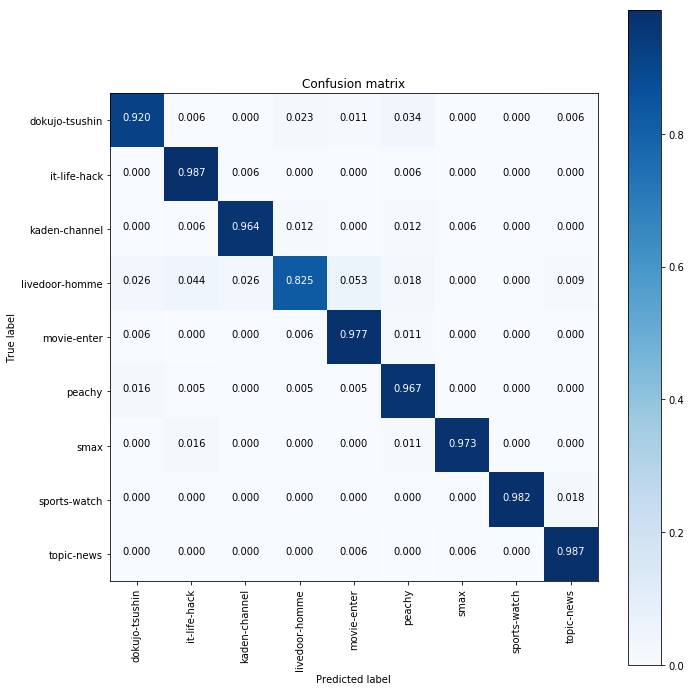

In [48]:
sys.path.append('..')
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(dev_df["label"], dev_df["predict"])
plot_confusion_matrix(conf_mat, target_names, normalize=True)